In [1]:
import sys

sys.path.append("../")
from sgm.modules.lipreader.lightnining import ModelModule
import torch


def get_lightning_module(ckpt_path):
    modelmodule = ModelModule()
    modelmodule.model.load_state_dict(torch.load(ckpt_path, map_location=lambda storage, loc: storage))
    return modelmodule


ckpt_path = "/vol/paramonos2/projects/antoni/code/Personal/lipreader/models/vsr_trlrs3_base.max400.pth"
model = get_lightning_module(ckpt_path)
model.eval()

/vol/paramonos2/projects/antoni/miniconda3/envs/svd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModelModule(
  (model): E2E(
    (encoder): Encoder(
      (to_timestep_cond): Sequential(
        (0): SinusoidalPosEmb()
        (1): Linear(in_features=64, out_features=256, bias=True)
        (2): SiLU()
      )
      (frontend): Conv3dResNetTimeConditioned(
        (trunk): ResNet(
          (layer1): mySequential(
            (0): BasicBlock(
              (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (relu1): SiLU(inplace=True)
              (relu2): SiLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (1): BasicBlock(
              (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn

In [11]:
import numpy as np
import torchvision
from sgm.modules.lipreader.preparation.detectors.retinaface.video_process import VideoProcess
from sgm.modules.lipreader.datamodule.transforms import VideoTransform

video_transform = VideoTransform(subset="val_w_noise", max_noise_level=250)
video_process = VideoProcess(convert_gray=False)
video_path = "/data2/Datasets/HDTF/cropped_videos_original/RD_Radio18_000.mp4"
video = torchvision.io.read_video(video_path, pts_unit="sec")[0].numpy()
landmarks = np.load("/data2/Datasets/HDTF/cropped_videos_original/RD_Radio18_000.npy")

In [12]:
video_proccessed = video_process(video, landmarks, True)
video_proccessed = torch.tensor(video_proccessed)
video_proccessed = video_proccessed.permute((0, 3, 1, 2))
video_proccessed, t = video_transform(video_proccessed)
t

tensor([41])

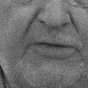

'L'

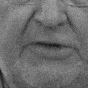

'L'

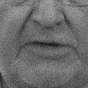

'L'

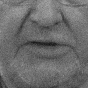

'L'

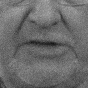

'L'

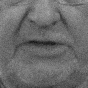

'L'

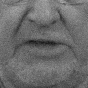

'L'

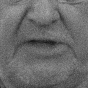

'L'

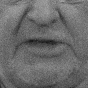

'L'

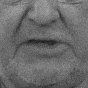

'L'

In [13]:
from PIL import Image

# Display first 10 frames video
for i in range(10):
    pil_image = (video_proccessed[i].permute(1, 2, 0).numpy() * 255).astype(np.uint8)

    display(Image.fromarray(pil_image.squeeze()), "L")

In [5]:
torch.cuda.empty_cache()

In [21]:
model = model.to("cuda")
duration = 10000


with torch.no_grad():
    input = video_proccessed[: 25 * duration].cuda()

    pred_noise = model(input, t=t.cuda())
    print(pred_noise)

    pred = model(input, t=None)
    print(pred)

SYSTEM LET ME GET THIS NEXT SLIDE BARS THAT GOVERNMENT RASH HOME OR CONFRONTED WITH AN INVESTIGATION IN PROSECUTION OF POLITICAL CRIMES REPUBLICANS ARE OPENING THE DOOR FOR ROLEING A SYSTEM AND CORRUPTION AND GOVERNMENT DEMOCRATS ARE COMMITTING TO MAKING SURE THAT DOESN'T HAPPEN IN THIS WAY WE'VE OFTEN SUFFERED SOLUTIONS THAT WOULD COMBAT POLITICAL CORRUPTION WE'RE SIGHTED WE WANT TO GET THE ADMIRESSSIONS THAT WE DON'T DO WHAT WE WANT TO DO TO BE CORTISSSED WE DON'T KNOW WHAT WE WANT TO BE CORTIMED BUT WE DON'T TO BERALANTS ARE TO BERIGHTS ARE TO BERALS ARE TO BERALD'RED'S ARE TO'REED TO'REED TO'SED TO
SYSTEM LET ME GET THIS NEXT SLIDE BARS THAT GOVERNMENT RASH HOME OR CONFRONTED WITH AN INVESTIGATION IN PROSECUTION OF POLITICAL CRIMES REPUBLICANS ARE OPENING THE DOOR FOR ROLEING A SYSTEM AND CORRUPTION AND GOVERNMENT DEMOCRATS ARE COMMITTING TO MAKING SURE THAT DOESN'T HAPPEN IN THIS WAY WE'VE OFTEN SUFFERED SOLUTIONS THAT WOULD COMBAT POLITICAL CORRUPTION WE'RE SIGHTED WE WANT TO GET

In [7]:
import torchaudio


def compute_word_level_distance(seq1, seq2):
    return torchaudio.functional.edit_distance(seq1.lower().split(), seq2.lower().split())